# Custom Stacking Regressor Model

#### Steps involved for building custom stacking regressor model:

a) Split my whole data obtained from feature engineering into train and test(80-20)<br>

b) Now, in the 80% train set, we split the train set into D1 and D2.(50-50).<br>

From this D1, we do sampling with replacement to create d1,d2,d3....dk(k samples).<br>

Now will create 'k' models and train each of these models with the samples. Each model will be trained on only one sample. These models are called base models. We can select the best models and its hyperparameters based on the previous findings. we will make sure that ‘k’ can be passed as an argument. 
<br>
c) Now we pass the D2 set to each of these k models; now, we will get k predictions for D2 from each of these models.<br>

d) Now, using these k predictions, we create a new dataset, for D2, we already know it's corresponding target values, so now we train a metamodel with these k predictions.<br>

e) Now, for model evaluation, we use the 20% data that we have kept as the test set. Pass that test set to each of the base models, and we will get 'k' predictions. Now we create a new dataset with these k predictions and pass it to our metamodel, and we will get the final prediction. Using this final prediction and the targets for the test set, we can calculate the model's performance score.
<br>


## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks,Sequential
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from datetime import datetime
from prettytable import PrettyTable
from tensorflow.keras import backend as K
import shutil,os
import pickle

## Importing Datasets

In [3]:
#pjm_final = pd.read_pickle("final_pjm_data.pkl")
pjm_final = pd.read_pickle("/content/drive/MyDrive/Case Study 1/final_pjm_stationary.pkl")
pjm_final['PJME_MW'] = np.expm1(pjm_final['PJME_MW'])
pjm_final.head()

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,,
2002-01-08 03:00:00,28375.0,0.297609,7.071068e-01,0.313937,0.707107,0.429240
2002-01-08 04:00:00,28542.0,0.291394,5.000000e-01,0.297609,0.866025,0.432506
2002-01-08 05:00:00,29261.0,0.294912,2.588190e-01,0.291394,0.965926,0.435912
2002-01-08 06:00:00,31348.0,0.310060,6.123234e-17,0.294912,1.000000,0.439369
2002-01-08 07:00:00,35335.0,0.354029,-2.588190e-01,0.310060,0.965926,0.443005


In [4]:
def performance_metrics(y_actual,y_predict):
    #y_actual = np.expm1(np.array(y_actual))
    #y_predict = np.expm1(np.array(y_predict))
    mape = np.mean(np.abs((y_actual-y_predict)/y_actual))*100
    mae = mean_absolute_error(y_actual,y_predict)
    mse = mean_squared_error(y_actual,y_predict)
    rmse = sqrt(mean_squared_error(y_actual,y_predict))
    return rmse,mae,mape,mse

In [5]:
def result_visualization(y,y_hat,title=None):
    #y = np.expm1(np.array(y))
    #y_hat = np.expm1(np.array(y_hat))
    plt.figure(figsize=(23,5))
    plt.plot(y,label='true')
    plt.plot(y_hat,label='predicted')
    #plt.xlim(dt(2016, 1, 1),dt(2018, 12, 31))
    plt.legend()
    plt.grid()
    plt.title(title)
    
    plt.show()

In [6]:
pjm_df_copy = pjm_final.copy()
pjm_df_copy = pjm_df_copy.reset_index()
pjm_df_copy = pjm_df_copy.drop('Datetime',axis=1)
pjm_df_copy.head()

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
0,28375.0,0.297609,7.071068e-01,0.313937,0.707107,0.429240
1,28542.0,0.291394,5.000000e-01,0.297609,0.866025,0.432506
2,29261.0,0.294912,2.588190e-01,0.291394,0.965926,0.435912
3,31348.0,0.310060,6.123234e-17,0.294912,1.000000,0.439369
4,35335.0,0.354029,-2.588190e-01,0.310060,0.965926,0.443005


In [ ]:
pjm_df_copy.shape

(145132, 6)

In [7]:
X = pjm_df_copy.drop('PJME_MW',axis=1).values
y = pjm_df_copy['PJME_MW'].values

## Dividing data into train test (80:20)

In [8]:
test_size_ml =29026
X_train = X[:-test_size_ml]
X_test = X[-test_size_ml:]
y_train = y[:-test_size_ml]
y_test = y[-test_size_ml:]
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))
print('X_train shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('y_train shape :',y_train.shape)
print('y_test shape :',y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
X_train shape : (116106, 5)
X_test shape : (29026, 5)
y_train shape : (116106,)
y_test shape : (29026,)


## Splitting training data (50:50)

In [9]:
train_1,train_2 = X_train[:58053],X_train[58053:]
y_1,y_2 = y_train[:58053],y_train[58053:]

print('train_1 shape :',train_1.shape)
print('train_2 shape :',train_2.shape)
print('y_1 shape :',y_1.shape)
print('y_2 shape :',y_2.shape)
print(type(train_1))
print(type(train_2))
print(type(y_1))
print(type(y_2))

train_1 shape : (58053, 5)
train_2 shape : (58053, 5)
y_1 shape : (58053,)
y_2 shape : (58053,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Building K Models

In [18]:
#https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array
def create_k_model(train_x,train_y,k,size):
    '''
    With this function we do sampling with replacement to create d1,d2,d3....dk(k samples)
    and then fits k different models'''
    k_models = []
    for x in range(k):
        sample = np.random.choice(len(train_x),size,replace=True)
        #sample = train_x.sample(frac=0.75,replace=True,random_state=None)
        #new_y = sample['PJME_MW']
        #new_x = sample.drop('PJME_MW',axis=1,inplace=True)
        new_x = train_x[sample]
        new_y = train_y[sample]
        rf_reg = RandomForestRegressor(n_estimators=1250,n_jobs=-1,bootstrap=True,max_depth=50,max_features='auto',
                           verbose=0,random_state=1)
        rf_reg.fit(new_x,new_y)
        k_models.append(rf_reg)
    return k_models
        

## Stacked Regressor on metadata with K Predictions

In [11]:
import contextlib
import io
import sys

@contextlib.contextmanager
def create_new_data(data,model):
    '''
    With this function using these k predictions, we create a new dataset, for D2,for which
    we already know it's corresponding target values
    '''
    new_data =[]
    for i in model:
        k_predict = i.predict(data)
        new_data.append(k_predict)
    new_data = np.array(new_data).T
    return new_data

## 1.SVR as stack Regressor

In [12]:
k_list = [20,50,100,150,200]
size = 5

In [ ]:
%%capture
# hypertuning k using svr as stack regressor

rmse_svr_score = []
svr_reg_model = []

for k in k_list:
    model = create_k_model(train_1,y_1,k,size)
    x_metadata = create_new_data(train_2,model)
    y_metadata = y_2
    
    parameters = {'C':[100,250,500,1000,5000],
             'gamma':['auto','scale'],
             'kernel':['rbf','linear','poly','sigmoid']}
    svr_reg = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_root_mean_squared_error', verbose=1,
                      n_jobs=-1,cv=3)
    svr_reg.fit(x_metadata,y_metadata)
    rmse_svr_score.append(svr_reg.best_score_)
    svr_reg_model.append(svr_reg.best_params_)
    


In [ ]:
print('\n')
print('Result for SVR as Stack Regressor')
print('For K :',k_list)
print('RMSE Score :',rmse_svr_score)
print('\n')
best_svr_parameter = svr_reg_model[np.argmin(rmse_svr_score)]
print('Best parameters :\n',best_svr_parameter)



Result for SVR as Stack Regressor
For K : [20, 50, 100, 150, 200]
RMSE Score : [-1014.0954142805813, -965.3086332827328, -796.1952838927492, -797.756196723704, -728.0834282698893]


Best parameters :
 {'C': 5000, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
#svr_file = '/content/drive/MyDrive/Case Study 1/svr_rmse.pkl'
#open_file = open(svr_file,'wb')
#pickle.dump(rmse_svr_score,open_file)
#open_file.close()

In [ ]:
#svr_best = '/content/drive/MyDrive/Case Study 1/svr_best_parameter.pkl'
#open_file = open(svr_best,'wb')
#pickle.dump(best_svr_parameter,open_file)
#open_file.close()

In [ ]:
#svr_file1 = '/content/drive/MyDrive/Case Study 1/svr_model.pkl'
#open_file = open(svr_file1,'wb')
#pickle.dump(svr_reg_model,open_file)
#open_file.close()

## 2.LightGBm as Stack Regressor

In [ ]:
%%capture
# hypertuning k using svr as stack regressor

rmse_lgbm_score = []
lgbm_reg_model = []

for k in k_list:
    model = create_k_model(train_1,y_1,k,size)
    x_metadata = create_new_data(train_2,model)
    y_metadata = y_2
    
    parameters = {"n_estimators":[50,100,250,500,1000,1250],
             "max_depth":[2,3,4,5,7,10],
             "learning_rate":[0.1,0.01,0.001]}
    lgbm_reg = GridSearchCV(lightgbm.LGBMRegressor(), param_grid = parameters,scoring='neg_root_mean_squared_error', verbose=1,
                      n_jobs=-1,cv=3)
    lgbm_reg.fit(x_metadata,y_metadata)
    rmse_lgbm_score.append(lgbm_reg.best_score_)
    lgbm_reg_model.append(lgbm_reg.best_params_)
    


In [ ]:
print('\n')
print('Result for LightGBM as Stack Regressor')
print('For K :',k_list)
print('RMSE Score :',rmse_lgbm_score)
print('\n')
best_lgbm_parameter = lgbm_reg_model[np.argmin(rmse_lgbm_score)]
print('Best parameters :\n',best_lgbm_parameter)



Result for LightGBM as Stack Regressor
For K : [20, 50, 100, 150, 200]
RMSE Score : [-911.7632525011509, -571.3943456610784, -559.9530922297777, -503.3029539873266, -474.6180951156619]


Best parameters :
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1250}


In [ ]:
lgbm_file = '/content/drive/MyDrive/Case Study 1/lgbm_rmse.pkl'
open_file = open(lgbm_file,'wb')
pickle.dump(rmse_lgbm_score,open_file)
open_file.close()

In [ ]:
#lgbm_best = '/content/drive/MyDrive/Case Study 1/lgbm_best_parameter.pkl'
#open_file = open(lgbm_best,'wb')
#pickle.dump(best_lgbm_parameter,open_file)
#open_file.close()

In [ ]:
#lgbm_file1 = '/content/drive/MyDrive/Case Study 1/lgbm_model.pkl'
#open_file = open(lgbm_file1,'wb')
#pickle.dump(lgbm_reg_model,open_file)
#open_file.close()

## 3.SGD Regressor as Stack Regressor

In [ ]:
%%capture
# hypertuning k using svr as stack regressor

rmse_sgd_score = []
sgd_reg_model = []

for k in k_list:
    model = create_k_model(train_1,y_1,k,size)
    x_metadata = create_new_data(train_2,model)
    y_metadata = y_2
    
    parameters = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100],
             'max_iter':[100,250,500,1000,1250],
             'penalty':['l1','l2','elasticnet'],
             'loss':['squared_epsilon_insensitive','squared_loss','huber','epsilon_insensitive']}
    sgd_reg = GridSearchCV(SGDRegressor(), param_grid = parameters,scoring='neg_root_mean_squared_error', verbose=1,
                      n_jobs=-1,cv=3)
    sgd_reg.fit(x_metadata,y_metadata)
    rmse_sgd_score.append(sgd_reg.best_score_)
    sgd_reg_model.append(sgd_reg.best_params_)
    


In [ ]:
print('\n')
print('Result for SGD as Stack Regressor')
print('For K :',k_list)
print('RMSE Score :',rmse_sgd_score)
print('\n')
best_sgd_parameter = sgd_reg_model[np.argmin(rmse_sgd_score)]
print('Best parameters :\n',best_sgd_parameter)



Result for SGD as Stack Regressor
For K : [20, 50, 100, 150, 200]
RMSE Score : [-12806.145782213476, -17760.999753142543, -6835.3119544736755, -15634.182175062757, -10076.272326719003]


Best parameters :
 {'alpha': 100, 'loss': 'huber', 'max_iter': 500, 'penalty': 'l1'}


In [ ]:
#sgd_file = '/content/drive/MyDrive/Case Study 1/sgd_rmse.pkl'
#open_file = open(sgd_file,'wb')
#pickle.dump(rmse_sgd_score,open_file)
#open_file.close()

In [ ]:
#sgd_best = '/content/drive/MyDrive/Case Study 1/sgd_best_parameter.pkl'
#open_file = open(sgd_best,'wb')
#pickle.dump(best_sgd_parameter,open_file)
#open_file.close()

In [ ]:
#sgd_file1 = '/content/drive/MyDrive/Case Study 1/sgd_model.pkl'
#open_file = open(sgd_file1,'wb')
#pickle.dump(sgd_reg_model,open_file)
#open_file.close()

## 4.Decision Tree as Stack Regressor

In [ ]:
%%capture
# hypertuning k using svr as stack regressor

rmse_dt_score = []
dt_reg_model = []

for k in k_list:
    model = create_k_model(train_1,y_1,k,size)
    x_metadata = create_new_data(train_2,model)
    y_metadata = y_2
    
    parameters = {'max_depth': [2, 5, 15, 25, 50, 75, 100],
                  'min_samples_split': [2, 3, 5, 7, 10],
                  'min_samples_leaf': [1, 3, 5],
                  'max_features': ['auto', 'sqrt', 'log2']}
    dt_reg = GridSearchCV(DecisionTreeRegressor(), param_grid = parameters,scoring='neg_root_mean_squared_error', verbose=1,
                      n_jobs=-1,cv=3)
    dt_reg.fit(x_metadata,y_metadata)
    rmse_dt_score.append(dt_reg.best_score_)
    dt_reg_model.append(dt_reg.best_params_)
    


In [ ]:
print('\n')
print('Result for Decision Tree as Stack Regressor')
print('For K :',k_list)
print('RMSE Score :',rmse_dt_score)
print('\n')
best_dt_parameter = dt_reg_model[np.argmin(rmse_dt_score)]
print('Best parameters :\n',best_dt_parameter)



Result for Decision Tree as Stack Regressor
For K : [20, 50, 100, 150, 200]
RMSE Score : [-874.4240132913059, -789.8135301716344, -743.3699044725128, -722.497050687704, -711.8861714865948]


Best parameters :
 {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10}


In [ ]:
#dt_file = '/content/drive/MyDrive/Case Study 1/dt_rmse.pkl'
#open_file = open(dt_file,'wb')
#pickle.dump(rmse_dt_score,open_file)
#open_file.close()

In [ ]:
#dt_best = '/content/drive/MyDrive/Case Study 1/dt_best_parameter.pkl'
#open_file = open(dt_best,'wb')
#pickle.dump(best_dt_parameter,open_file)
#open_file.close()

In [ ]:
#dt_file1 = '/content/drive/MyDrive/Case Study 1/dt_model.pkl'
#open_file = open(dt_file1,'wb')
#pickle.dump(dt_reg_model,open_file)
#open_file.close()

## 5.KNN as Stack Regressor

In [ ]:
%%capture
# hypertuning k using svr as stack regressor

rmse_knn_score = []
knn_reg_model = []

for k in k_list:
    model = create_k_model(train_1,y_1,k,size)
    x_metadata = create_new_data(train_2,model)
    y_metadata = y_2
    
    parameters = {'n_neighbors':[5,10,20,30,40,50],
                  'weights':['uniform','distance']}
    knn_reg = GridSearchCV(KNeighborsRegressor(), param_grid = parameters,scoring='neg_root_mean_squared_error', verbose=1,
                      n_jobs=-1,cv=3)
    knn_reg.fit(x_metadata,y_metadata)
    rmse_knn_score.append(knn_reg.best_score_)
    knn_reg_model.append(knn_reg.best_params_)
    


In [ ]:
print('\n')
print('Result for KNN as Stack Regressor')
print('For K :',k_list)
print('RMSE Score :',rmse_knn_score)
print('\n')
best_knn_parameter = knn_reg_model[np.argmin(rmse_knn_score)]
print('Best parameters :\n',best_knn_parameter)



Result for KNN as Stack Regressor
For K : [20, 50, 100, 150, 200]
RMSE Score : [-873.8411426641047, -754.9510017944834, -734.8032022319294, -714.9769001971896, -697.4154431227952]


Best parameters :
 {'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
#knn_file = '/content/drive/MyDrive/Case Study 1/knn_rmse.pkl'
#open_file = open(knn_file,'wb')
#pickle.dump(rmse_knn_score,open_file)
#open_file.close()

In [ ]:
#knn_best = '/content/drive/MyDrive/Case Study 1/knn_best_parameter.pkl'
#open_file = open(knn_best,'wb')
#pickle.dump(best_knn_parameter,open_file)
#open_file.close()

In [ ]:
#knn_file1 = '/content/drive/MyDrive/Case Study 1/knn_model.pkl'
#open_file = open(knn_file1,'wb')
#pickle.dump(knn_reg_model,open_file)
#open_file.close()

## Compairing Custom Models

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ("Model Name", "Value of k", "RMSE Score")
table.add_row(["RF + SVR", 200, 728.083])
table.add_row(["RF + LightGBM", 200, 474.618])
table.add_row(["RF + SGD", 100, 6835.311])
table.add_row(["RF + Decision Tree", 200, 711.866])
table.add_row(["RF + KNN", 200, 697.415])
print(table)

+--------------------+------------+------------+
|     Model Name     | Value of k | RMSE Score |
+--------------------+------------+------------+
|      RF + SVR      |    200     |  728.083   |
|   RF + LightGBM    |    200     |  474.618   |
|      RF + SGD      |    100     |  6835.311  |
| RF + Decision Tree |    200     |  711.866   |
|      RF + KNN      |    200     |  697.415   |
+--------------------+------------+------------+


### Observations:
The best custom model was LightGBM Regressor model on top of Random Forest Regressor having RMSE Score = 481.111 for k = 200,learning_rate = 0.1,max_depth=10,n_estimator = 1250

## Prediction on Test Data with Best Custom Model

In [19]:
def custom_ensemble(X_train,y_train,X_test,k,size=5,split=29026):
    '''
    This function will do everything from dividing training data to two equal parts train_1 and train_2
    and creating metadata for test data and to predict from the metamodels.
    This function returns the predictions for X_test.
    k = no of base models
    '''
    #splitting the X_train into 50:50
    train_1 = X_train[:split]
    train_2 = X_train[split:]
    y_1 = y_train[:split]
    y_2 = y_train[split:]
    print('X_train type :',type(X_train))
    print('X_train type :',type(X_test))
    print('X_train type :',type(y_train))
    print('X_train type :',type(y_test))
    print('train_1 type :',type(train_1))
    print('train_2 type :',type(train_2))
    print('y_1 type :',type(y_1))
    print('y_2 type :',type(y_2))
    print('X_train shape :',X_train.shape)
    print('X_test shape :',X_test.shape)
    print('y_train shape :',y_train.shape)
    print('train_1 shape :',train_1.shape)
    print('train_2 shape :',train_2.shape)
    print('y_1 shape :',y_1.shape)
    print('y_2 shape :',y_2.shape)
    #creating base models using train_1 and y_1
    k_models = create_k_model(train_1,y_1,k,size);
    #creating metadat using train_2 and base models obtained above
    x_new_metadata = create_new_data(train_2,k_models);
    #using the best custom model to fit the new meta data
    lgbm_reg = lightgbm.LGBMRegressor(n_estimator = 1250,max_depth=10,learning_rate=0.1,n_jobs=-1);
    lgbm_reg.fit(x_new_metadata,y_2);
    #creating metadata  for test data
    x_test_metadata = create_new_data(X_test,k_models);
    #predicting the test metadata
    lgbm_custom_prediction = lgbm_reg.predict(x_test_metadata);
    return lgbm_custom_prediction

In [20]:
%%time
#%%capture
lgbm_custom_prediction = custom_ensemble(X_train,y_train,X_test,k=200,size=5,split=58053);

X_train type : <class 'numpy.ndarray'>
X_train type : <class 'numpy.ndarray'>
X_train type : <class 'numpy.ndarray'>
X_train type : <class 'numpy.ndarray'>
train_1 type : <class 'numpy.ndarray'>
train_2 type : <class 'numpy.ndarray'>
y_1 type : <class 'numpy.ndarray'>
y_2 type : <class 'numpy.ndarray'>
X_train shape : (116106, 5)
X_test shape : (29026, 5)
y_train shape : (116106,)
train_1 shape : (58053, 5)
train_2 shape : (58053, 5)
y_1 shape : (58053,)
y_2 shape : (58053,)
CPU times: user 12min 11s, sys: 1min 37s, total: 13min 49s
Wall time: 10min 20s


RSME : 465.8696091379984
MAE : 335.35856636186884
MAPE : 1.0842985944593606
MSE : 217034.49271839138


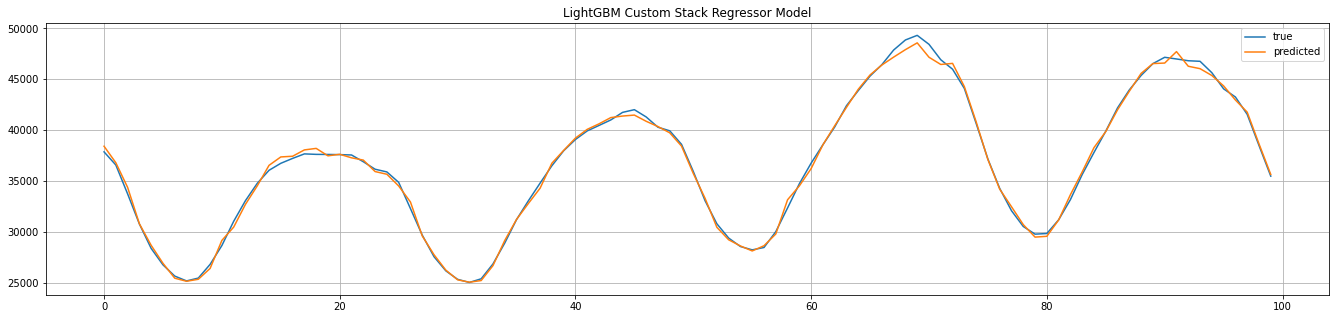

In [ ]:
rmse_lgbm1,mae_lgbm1,mape_lgbm1,mse_lgbm1 = performance_metrics(y_test,lgbm_custom_prediction)
print('RSME :',rmse_lgbm1)
print('MAE :',mae_lgbm1)
print('MAPE :',mape_lgbm1)
print('MSE :',mse_lgbm1)

result_visualization(y_test[-100:],lgbm_custom_prediction[-100:],title='LightGBM Custom Stack Regressor Model')

## Compairing results with Random Forest from Modelling Part-1 

In [ ]:
result = PrettyTable()
result.field_names = ["Model","RMSE","MAE","MAPE","MSE"]
result.add_row(["RF + LightGBM Custom Stack Regressor Model",465.869,335.358,1.08,217034])
result.add_row(["Random Forest Model (Modelling Part-1)",274.871,198.227,0.539,75554.60])
print(result)

+--------------------------------------------+---------+---------+-------+---------+
|                   Model                    |   RMSE  |   MAE   |  MAPE |   MSE   |
+--------------------------------------------+---------+---------+-------+---------+
| RF + LightGBM Custom Stack Regressor Model | 465.869 | 335.358 |  1.08 |  217034 |
|   Random Forest Model (Modelling Part-1)   | 274.871 | 198.227 | 0.539 | 75554.6 |
+--------------------------------------------+---------+---------+-------+---------+


## Observations/Results:
From the above observation and results in can be seen that the stack model has performed much better that all some machine leraning models and deep learning models but not performed best as compare to Random Forest when used solely in Modelling part-1.<br>
So finally we will choose data set obtained after feature engineering and will use Random Forest Model for future data prediction because of following reasons:
1. RMSE is very low for Random Forest as compare to stack custom model
2. In real life,when model is deployed it need to re-train time to time so that it should work properly and training time for Random Forest is much much less (few inutes) as comapred to custom stack model(few hours).